In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timedelta
from fredapi import Fred
import quandl

In [3]:
def get_info(names):
    data = []
    for i in range(len(names)):
        data.append(fred.get_series(names[i]).to_frame().rename(columns={0:names[i]}))
        data[i] = data[i].groupby(data[i].index.year).mean().dropna()
    return data

In [4]:
# https://github.com/mortada/fredapi
fred = Fred(api_key="a02df0a22c57860f5f7cf25edc70ffb3")
quandl.ApiConfig.api_key = "QZLZXdHDDPZna9Yw48NP"

# Northeast - New York

Define the variables to be used in analysis:

X attributes: 
* *Monthly* Stocks
    * S&P 500 (MULTPL/SP500_REAL_PRICE_MONTH)
* *Quarterly* Gross Domestic Product (GDP)
* *Annual* Unemployment Rate (LAUST360000000000003A)
* *Annual* House Ownership Ratio (NYHOWN)
* *Annual* Resident Population (NYPOP)
* *Annual* Median Income Rate (MEHOINUSNYA672N)
* *Annual* Home Vacancy Rate (NYHVAC)

y attributes:
* *Quarterly* New York State Housing Price Index (NYSTHPI)

Connect to APIs and create a dataframe with information from each dataset:

In [5]:
sp500 = quandl.get('MULTPL/SP500_REAL_PRICE_MONTH').rename(columns={'Value':'SP500'})
sp500 = sp500.groupby(sp500.index.year).mean().dropna()
names_ny = ['LAUST360000000000003A', "NYHOWN","NYPOP", "MEHOINUSNYA672N", "NYHVAC", 'GDP']
ny_data_series = get_info(names_ny) + [sp500]

In [6]:
# quarterly housing price index
nyHPI = fred.get_series('NYSTHPI').to_frame()
nyHPI.index.name = "DATE"
nyHPI = nyHPI.rename(columns={0:"NYSTHPI"})
# convert to annual
nyHPI_annual = nyHPI.groupby(nyHPI.index.year).mean()

In [7]:
ny_annual = nyHPI_annual.copy()
for df in ny_data_series:
    ny_annual = ny_annual.merge(df, left_index=True, right_index=True)
ny_annual.tail()

,NYSTHPI,LAUST360000000000003A,NYHOWN,NYPOP,MEHOINUSNYA672N,NYHVAC,GDP,SP500
2014,570.9975,6.3,52.9,19656.330,57662.0,1.7,17527.25825,1930.667500
2015,591.8425,5.3,51.5,19661.411,61480.0,2.0,18224.78025,2061.199167
2016,613.9100,4.9,51.5,19641.589,64288.0,2.0,18715.04050,2091.844167
2017,644.7200,4.7,51.1,19590.719,63043.0,2.1,19519.42350,2448.217500
2018,682.2450,4.1,51.0,19542.209,67274.0,1.7,20580.22300,2744.680000


Analyze the correlation coefficient for each indicator we have specified:

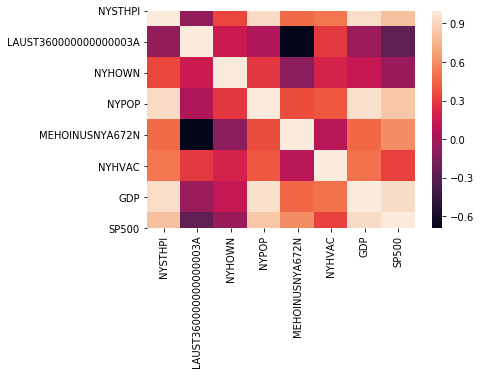

In [8]:
corr = ny_annual.corr().round(4)
sns.heatmap(data=corr)

In [9]:
corr

,NYSTHPI,LAUST360000000000003A,NYHOWN,NYPOP,MEHOINUSNYA672N,NYHVAC,GDP,SP500
NYSTHPI,1.0000,-0.0679,0.3505,0.9229,0.4768,0.5110,0.9399,0.8121
LAUST360000000000003A,-0.0679,1.0000,0.1524,0.0372,-0.6925,0.2963,-0.0336,-0.2694
NYHOWN,0.3505,0.1524,1.0000,0.2901,-0.1009,0.2004,0.1265,-0.0416
NYPOP,0.9229,0.0372,0.2901,1.0000,0.3714,0.4056,0.9473,0.8360
MEHOINUSNYA672N,0.4768,-0.6925,-0.1009,0.3714,1.0000,0.0780,0.4602,0.5971
NYHVAC,0.5110,0.2963,0.2004,0.4056,0.0780,1.0000,0.4934,0.3226
GDP,0.9399,-0.0336,0.1265,0.9473,0.4602,0.4934,1.0000,0.9316
SP500,0.8121,-0.2694,-0.0416,0.8360,0.5971,0.3226,0.9316,1.0000


Create a model using linear regression to express the Case-Schiller index as dependent on the other datasets we have downloaded:

In [10]:
X = ny_annual.drop(columns=['NYSTHPI'], axis=1)
Y = ny_annual['NYSTHPI']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R-Squared score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R-Squared score is {}'.format(r2))

The model performance for training set
--------------------------------------
Root Mean Squared Error is 20.550389410992903
R-Squared score is 0.9820594540751048


The model performance for testing set
--------------------------------------
Root Mean Squared Error is 31.309697006192742
R-Squared score is 0.952166261889279
